# **Numerical Solution of 1D Time Dependent Schrödinger Equation by Split Operator Fourier Transform (SOFT) Method**

**Authors:** Dou Du, Taylor James Baird and Sara Bonella

<i class="fa fa-home fa-2x"></i><a href="../index.ipynb" style="font-size: 20px"> Go back to index</a>

**Source code:** https://github.com/osscar-org/quantum-mechanics/blob/master/notebook/quantum-mechanics/soft.ipynb

This notebook presents the Split Operator Fourier Transform (SOFT) numerical method for solving the one-dimensional time-dependent Schrödinger equation.
<hr style="height:1px;border:none;color:#cccccc;background-color:#cccccc;" />

## **Goals**
* Use the SOFT method to observe the evolution of a quantum mechanical system in the coordinate ($X$) and momentum ($P$) representations using different potentials.
* Background theory: understand the steps involved in the SOFT algorithm and how they are translated to code.
* Explore how the performance of the simulations depends on different core parameters.
* As in the first point, observe the evolution of the system in the position and momentum representations and take note of the manifestation of Heisenberg's uncertainty principle.

## **Background theory**

[**More in the background theory.**](./theory/theory_soft.ipynb)

## **Tasks and exercises**

<ol style="text-align: justify;font-size:15px">
    <li> Investigate the dependence on timestep of the stability of the dynamics (move the slider for $dt$ and monitor the total energy of the system and norm of the wavefunction).
    <details>
    <summary style="color: red">Solution</summary>
        Observe that as the timestep employed in the simulation is increased, the conservation of total energy of the system degrades until eventually the timestep is so large that the dynamics becomes totally unstable. The reason why this integration scheme does not conserve total energy exactly may be attributed to the non-commutativity of the split-operator propagator with the Hamiltonian. It is worth noting, however, that norm conservation is maintained even as one increases the timestep. This latter fact is due to the unitarity of the propagator in the split-operator scheme.
    </details>
    </li>
    <li> What dictates the maximum size of the timestep that we can use for the SOFT algorithm (consider the main assumptions/approximations that are made when formulating the propagation scheme for SOFT).
    <details>
    <summary style="color: red">Solution</summary>
    Recall that the central approximation used in the derivation of the SOFT propagation scheme is in the truncation of the Trotter product formula: $e^{A+B} = \lim\limits_{P \to \infty} (e^{\frac{A}{P}} e^{\frac{B}{P}})^{P} \approx (e^{\frac{A}{N}} e^{\frac{B}{N}})^{N}$ for $N$ sufficiently large. This approximation becomes more and more accurate the larger we make the value of $N$. In our specific case we have $e^{\frac{it}{\hbar} (\hat{T} + \hat{V} )}$ and we approximate this via the product 
        $(e^{\frac{it}{\hbar N_{\text{steps}}}\hat{T} } e^{\frac{it}{\hbar N_{\text{steps}}}\hat{V} })^{N_{\text{steps}}}$ where $N_{\text{steps}}\cdot dt = t$. This approximation therefore becomes increasingly more accurate the larger $N_{\text{steps}}$ (or equivalently the smaller we make $dt$).
    </details>
    </li>
    <li> Why is the use of the SOFT algorithm unfeasible for larger systems (think about how much data is needed to represent the state of the system on a computer and how many operations are required to carry out the propagation)?
    <details>
    <summary style="color: red">Solution</summary>
    In order to implement the SOFT algorithm on a computer it is necessary to discretize the nuclear wavefunction. To do so, we must introduce a grid of points that make up the space throughout which the wavefunction extends. Say that for each dimension of the grid we use $N$ grid points. For a system in $d$ dimensions, this means that we shall require $N^d$ points to represent the wavefunction of a single nucleus. Now, if we want to instead consider a system of, say $n$ nuclei, then we find that a total number of $N^{nd}$ grid points are required. In other words, the amount of data required to represent our system scales exponentially with increasing system size. Moreover, since we must loop over each of these grid points to carry out the time evolution of our system - the number of operations required also scales exponentially. This is what renders the SOFT algorithm unsuitable for large systems.
    </details>
    </li>
    <li> Observe the evolution of the wavefunction in both position and momentum space. Do you notice the manifestation of Heisenberg's uncertainty principle? Can you explain it?
        <details>
    <summary style="color: red">Solution</summary>
    The top figure shows the relation between position $x$ and the modulus of the wavefunction $|\psi|$.
    On the other hand, the bottom figure shows the relation between momentum $p$ and the modulus of the wavefunction, $|\psi|$. Using the Harmonic potential for example, one
    can clearly see that when the position of the particle is known with greater certainty (a sharp peak of the $|\psi(x)|$), the $|\psi(p)|$ will have
    a boarder shape. The phenomenon is always true during all the time.
    </details>
    </li>

<hr style="height:1px;border:none;color:#cccccc;background-color:#cccccc;" />

## Interactive visualization
(be patient, it might take a few seconds to load)

In [33]:
%matplotlib widget

import numpy as np
from math import pi
from scipy.fftpack import fft, ifft
from ipywidgets import Button, FloatSlider, HBox, VBox, IntProgress
from ipywidgets import Dropdown, Layout, Accordion, Label
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import animation
from datetime import datetime


In [34]:
class SOFT(object):
    """
    This is the Split Operator Fourier Transform (SOFT)
    x: the grid space 
    psi_0: inital wavefunction, included real and image parts
    V: the potential
    dt: the time interval
    hbar: the Plank constant (default value 1.0 as atomic unit)
    m: the mass (default value 1.0 as atomic unit)
    """
    
    def __init__(self, x, psi_0, V, dt, hbar=1.0, m = 1.0):
        self.N = len(x);
        self.hbar = hbar;
        self.m = m;
        
        dx = x[1] -x [0];
        dk = (2*pi)/(self.N*dx);
        
        self.x = x;
        self.dx = dx;
        self.dk = dk;
        self.t = 0.0;
        self.dt = dt;
        self.tot_steps=100000;
        self.tarr=self.dt*np.arange(self.tot_steps)
        self.m = m;
        
        self.k_x = -0.5*self.N*self.dk + dk*np.arange(self.N);
        self.psi_x = np.zeros((self.N), dtype=np.complex128)
        self.psi_k = np.zeros((self.N), dtype=np.complex128)
        self.psi_mod_x = np.zeros((self.N), dtype=np.complex128)
        self.psi_mod_k = np.zeros((self.N), dtype=np.complex128)
        
        self.ekint = np.array([np.nan]*self.tot_steps)
        self.epot  = np.array([np.nan]*self.tot_steps)
        self.norm  = np.array([np.nan]*self.tot_steps)
        
        self.psi_x = psi_0;
        self._periodic_bc();
        
        if callable(V):
            self.V = V(x)
        else:
            self.V = V
            
        self.psi_mod_x[:] = self.dx/np.sqrt(2*pi)*self.psi_x[:]*np.exp(-1.0j*self.k_x[0]*self.x);
        
    def _periodic_bc(self):
        self.psi_x[-1] = self.psi_x[0]
               
    def _half_pot_prop(self, ft=True):
        if ft == True:
            self.psi_mod_x[:] = ifft(self.psi_mod_k[:])
        self.psi_mod_x[:] = self.psi_mod_x[:]*np.exp(-1.0j*(self.dt/2.0)*self.V)

    def _full_kinetic_prop(self):
        self.psi_mod_k[:] = fft(self.psi_mod_x[:])
        self.psi_mod_k[:] = self.psi_mod_k[:]*np.exp(-1.0j*self.k_x**2*self.dt/(2.0*self.m))
        
    def _compute_psi(self):
        self.psi_x[:] = (np.sqrt(2*pi)/self.dx)*self.psi_mod_x*np.exp(1.0j*self.k_x[0]*self.x)
        self.psi_k[:] = self.psi_mod_k*np.exp(-1.0j*self.x[0]*self.dk*np.arange(self.N))
        
    def get_kinetic_energy(self):
        ke = 0.5*(1./self.m)*sum(self.k_x**2*np.absolute(self.psi_k)**2)*self.dk
        self.ekint[int(self.t/self.dt)] = ke

    
    def get_potential_energy(self):
        epot = sum(np.conj(self.psi_x)*self.V*self.psi_x)*self.dx
        self.epot[int(self.t/self.dt)] = epot
    
    def get_norm(self):
        self.norm[int(self.t/self.dt)] = sum(np.conj(self.psi_x)*self.psi_x)*self.dx
        
             
    def evolution(self, Nsteps=1):
        for i in range(Nsteps):
            self._half_pot_prop(ft = False)
            self._full_kinetic_prop()
            self._half_pot_prop(ft = True)
        self._compute_psi()
        self.get_kinetic_energy()
        self.get_norm()
        self.get_potential_energy()
        self.psi_mod_x /= np.sqrt((abs(self.psi_mod_x)**2).sum()*2*pi/self.dx);
        self.t += self.dt*Nsteps
        

In [35]:
######################################################################
# Helper functions for gaussian wave-packets
def gauss_x(x, a, x0, k0):
    """
    a gaussian wave packet of width a, centered at x0, with momentum k0
    """
    return ((a * np.sqrt(np.pi)) ** (-0.5)
            * np.exp(-0.5 * ((x - x0) * 1. / a) ** 2 + 1j * x * k0))


def gauss_k(k, a, x0, k0):
    """
    analytical fourier transform of gauss_x(x), above
    """
    return ((a / np.sqrt(np.pi)) ** 0.5
            * np.exp(-0.5 * (a * (k - k0)) ** 2 - 1j * (k - k0) * x0))


######################################################################
# Utility functions for running the animation
def theta(x):
    """
    theta function :
      returns 0 if x<=0, and 1 if x>0
    """
    x = np.asarray(x)
    y = np.zeros(x.shape)
    y[x > 0] = 1.0
    return y


def square_barrier(x, width, height):
    return height * (theta(x + 0.5*width) - theta(x - 0.5*width))

def parabola(x, a=1.0, x0 = 0.0):
    return a/1000.0*(x-x0)**2

def morse(x, D = 1.0, b = 0.03, x0 = -60.0):
    return D*(np.exp(-2.0*b*(x-x0))-2*np.exp(-b*(x-x0))) + D


In [36]:
######################################################################
# Create the animation

# specify time steps and duration
dt = 0.01
N_steps = 50
t_max = 120
frames = int(t_max / float(N_steps * abs(dt)))

# specify constants
hbar = 1.0   # planck's constant
m = 1.9      # particle mass

# specify range in x coordinate
N = 2 ** 11
dx = 0.1
x = dx * (np.arange(N) - 0.5 * N)

# specify potential
V0 = 1.5
L = hbar / np.sqrt(2 * m * V0)
a = 30 * L
x0 = -60 * L

# specify initial momentum and quantities derived from it
p0 = np.sqrt(2 * m * 0.2 * V0)
dp2 = p0 * p0 * 1. / 80
d = hbar / np.sqrt(2 * dp2)

k0 = p0 / hbar
v0 = p0 / m
psi_x0 = gauss_x(x, d, x0, k0)

In [37]:
style = {'description_width': 'initial'}

pot_select = Dropdown(
    options=['1. Box potential', '2. Morse potential', '3. Harmonic potential'],
    index = 0,
    description='Potential type:',
    disabled=False,
    style = style
)

layout_hidden  = widgets.Layout(visibility = 'hidden')
layout_visible = widgets.Layout(visibility = 'visible')

# Set the depth and wide of the box potential (pot1)
swide = FloatSlider(value = a, min = 0.0, max = 2*a, description = 'Width: ');
sheight = FloatSlider(value = V0, min = 0.0, max = 2*V0, description = 'Height: ');
swide.layout = layout_visible
sheight.layout = layout_visible

#Set the parameter for the Morse potential (pot2)
pot2_D  = FloatSlider(value = 1.0, min = 1.0, max = 5.0, description = 'D: ');
pot2_b  = FloatSlider(value = 0.03, min = 0.01, max = 0.10, step=0.01, description = 'b: ');
pot2_x0 = FloatSlider(value = -60.0, min = -100.0, max = 100.0, description = 'x0: ');

pot2_D.layout = layout_hidden
pot2_b.layout = layout_hidden
pot2_x0.layout = layout_hidden

#Set the parameter for the Harmonic potential (pot3)
pot3_a = FloatSlider(value = 1.0, min = 0.2, max = 2.0, description = 'a: ');
pot3_x0 = FloatSlider(value = 0.0, min = -100.0, max = 100.0, description = 'x0: ');
pot3_a.layout = layout_hidden
pot3_x0.layout = layout_hidden

#Show the potential image
file1 = open("images/pot1.png", "rb")
image1 = file1.read()
file2 = open("images/pot2.png", "rb")
image2 = file2.read()
file3 = open("images/pot3.png", "rb")
image3 = file3.read()

pot_img = widgets.Image(
    value=image1,
    format='png',
    width=300,
    height=400,
)

pot_img.layout = layout_visible

def pot_change(change):
    global V_x
    if pot_select.index == 0:
        swide.layout = layout_visible
        sheight.layout = layout_visible
        pot2_D.layout = layout_hidden
        pot2_b.layout = layout_hidden
        pot2_x0.layout = layout_hidden
        pot3_a.layout = layout_hidden
        pot3_x0.layout = layout_hidden
        pot_img.layout = layout_visible
        pot_img.value = image1
    elif pot_select.index == 1:
        swide.layout = layout_hidden
        sheight.layout = layout_hidden
        pot2_D.layout = layout_visible
        pot2_b.layout = layout_visible
        pot2_x0.layout = layout_visible
        pot3_a.layout = layout_hidden
        pot3_x0.layout = layout_hidden
        pot_img.layout = layout_visible
        pot_img.value = image2                
    elif pot_select.index == 2:
        swide.layout = layout_hidden
        sheight.layout = layout_hidden
        pot2_D.layout = layout_hidden
        pot2_b.layout = layout_hidden
        pot2_x0.layout = layout_hidden
        pot3_a.layout = layout_visible
        pot3_x0.layout = layout_visible
        pot_img.layout = layout_visible
        pot_img.value = image3  
        
pot_select.observe(pot_change, names='value', type='change');

def on_pot_update(event):
    global V_x, S
    if pot_select.index == 0:
        V_x = square_barrier(x, swide.value, sheight.value)
        V_x[x < -98] = 100.
        V_x[x > 98] = 100.
    elif pot_select.index == 1:
        V_x = morse(x, pot2_D.value, pot2_b.value, pot2_x0.value)
    elif pot_select.index == 2:
        V_x = parabola(x, pot3_a.value, pot3_x0.value)
    V_x_line.set_data(x, V_x)
    on_init_change('para')

pot_update = Button(description="Update potential")
pot_update.on_click(on_pot_update)

label1 = Label("(Pause the simulation to change the potential)")

# The accordion for the potential
pot_accordion = Accordion(children=[VBox([pot_select, pot_img,
                   HBox([swide, sheight]),
                   HBox([pot2_D, pot2_b]), pot2_x0,
                   HBox([pot3_a, pot3_x0]),
                   HBox([pot_update, label1])])], selected_index = None)

pot_accordion.set_title(0, "Select potential and set parameters")
display(pot_accordion)

Accordion(children=(VBox(children=(Dropdown(description='Potential type:', options=('1. Box potential', '2. Mo…

In [38]:
w_mass = FloatSlider(value = 1.0, min = 0.2, max=5.0, description="mass: ") 
w_dt = FloatSlider(value = 0.01, min = 0.01, max = 1.0, step=0.01, description="dt: ")

def on_mass_change(change):
    global m
    m = w_mass.value;
    
def on_dt_change(change):
    global dt
    dt = w_dt.value;

w_mass.observe(on_mass_change, names='value')
w_dt.observe(on_dt_change, names='value')

In [39]:
V_x = square_barrier(x, a, V0)
V_x[x < -98] = 100
V_x[x > 98] = 100

S = SOFT(x = x, dt = dt, psi_0=psi_x0, V=V_x, hbar=hbar, m=m)
S.evolution(1)

def on_init_change(b):
    global S
    psi_x0 = gauss_x(x, d, x0, k0)
    S = SOFT(x = x, dt = dt, psi_0=psi_x0, V=V_x, hbar=hbar, m=m)
    S.evolution(1)
    setup_plot()
    
def setup_plot():
    psi_x_line.set_data(S.x, 4 * abs(S.psi_x))
    psi_x_real.set_data(S.x, 4 * S.psi_x.real)
    psi_x_imag.set_data(S.x, 4 * S.psi_x.imag)
    V_x_line.set_data(S.x, S.V)
    psi_k_line.set_data(S.k_x, abs(S.psi_k))
    title.set_text("t = %-5i" % S.t)
    
w_init = Button(description="Update parameters");
w_init.on_click(on_init_change)

label2 = Label("(Pause the simulation to change the parameters)")

para_accordion = Accordion(children=[VBox([HBox([w_mass, w_dt]), 
                                           HBox([w_init, label2])])], 
                           selected_index = None)
para_accordion.set_title(0, "Set simulation parameters")
display(para_accordion)

/tmp/ipykernel_916868/673579290.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  self.norm[int(self.t/self.dt)] = sum(np.conj(self.psi_x)*self.psi_x)*self.dx
/tmp/ipykernel_916868/673579290.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self.epot[int(self.t/self.dt)] = epot


Accordion(children=(VBox(children=(HBox(children=(FloatSlider(value=1.0, description='mass: ', max=5.0, min=0.…

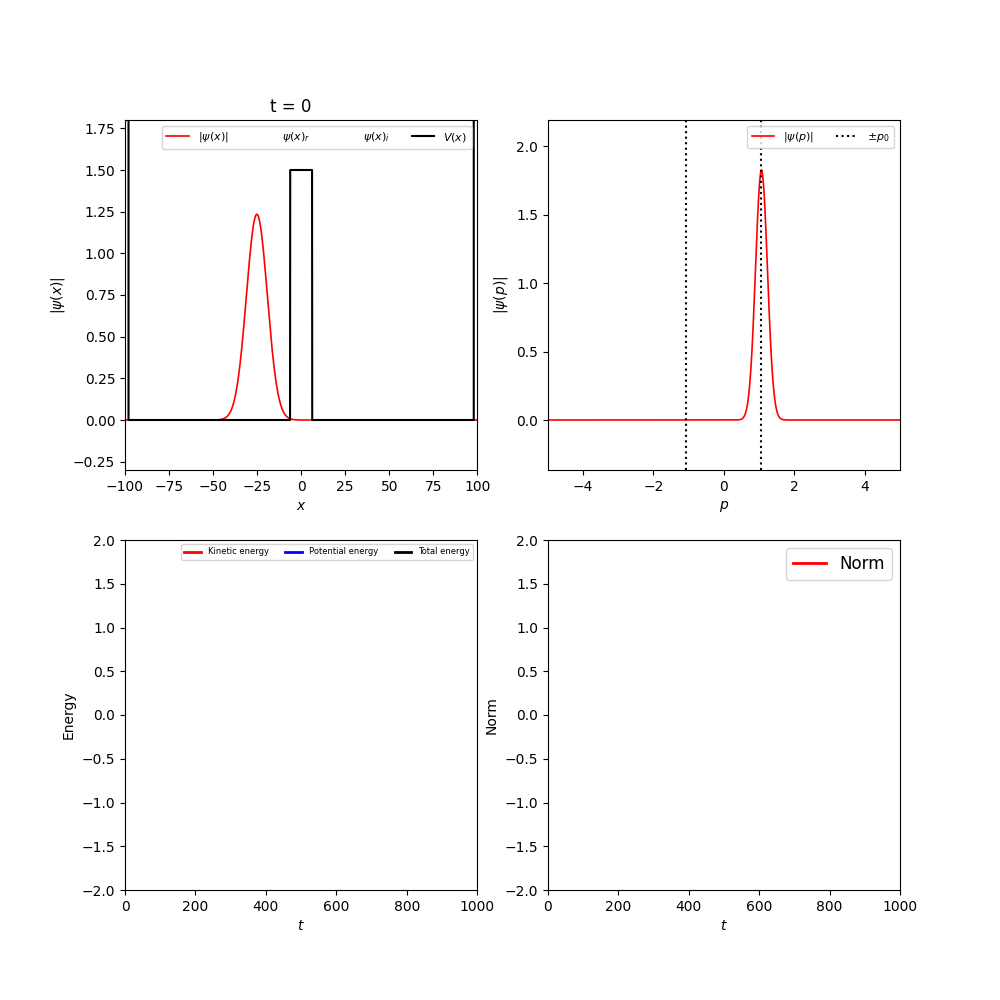

Button(description='Play', style=ButtonStyle())

In [40]:
######################################################################
# Set up plot

fig = plt.figure(figsize=(10, 10))
fig.canvas.header_visible = False

# plotting limits
xlim = (-100, 100)
klim = (-5, 5)

# top axes show the x-space data
ymin = 0
ymax = V0
ax1 = fig.add_subplot(221, xlim=xlim,
                      ylim=(ymin - 0.2 * (ymax - ymin),
                            ymax + 0.2 * (ymax - ymin)))
psi_x_line, = ax1.plot([], [], c='r', label=r'$|\psi(x)|$', linewidth=1.2)
psi_x_real, = ax1.plot([], [], c='b', label=r'$\psi(x)_r$', linewidth=0.8)
psi_x_imag, = ax1.plot([], [], c='orange', label=r'$\psi(x)_i$', linewidth=0.8)
V_x_line, = ax1.plot([], [], c='k', label=r'$V(x)$')

psi_x_line.set_visible(True)
psi_x_real.set_visible(False)
psi_x_imag.set_visible(False)

title = ax1.set_title("")
ax1.legend(prop=dict(size=8), ncol=4, loc=1)
ax1.set_xlabel('$x$')
ax1.set_ylabel(r'$|\psi(x)|$')

# bottom axes show the k-space data
ymin = abs(S.psi_k).min()
ymax = abs(S.psi_k).max()
ax2 = fig.add_subplot(222, xlim=klim,
                      ylim=(ymin - 0.2 * (ymax - ymin),
                            ymax + 0.2 * (ymax - ymin)))
psi_k_line, = ax2.plot([], [], c='r', label=r'$|\psi(p)|$', linewidth=1.2)

p0_line1 = ax2.axvline(-p0 / hbar, c='k', ls=':', label=r'$\pm p_0$')
p0_line2 = ax2.axvline(p0 / hbar, c='k', ls=':')


ax2.legend(prop=dict(size=8), ncol=4, loc=1)
ax2.set_xlabel('$p$')
ax2.set_ylabel(r'$|\psi(p)|$')

# axis for energy plots
ax3 = fig.add_subplot(223, xlim=(0,S.tot_steps*S.dt),ylim=(-2.,2.))
# axis for norm plot
ax4 = fig.add_subplot(224, xlim=(0,S.tot_steps*S.dt), ylim=(-2,2)) 


ke_line, = ax3.plot([], [], c='r', label=r'Kinetic energy', linewidth=2.0)
pe_line, = ax3.plot([], [], c='b', label=r'Potential energy', linewidth=2.0)
tot_e_line, = ax3.plot([], [], c='black', label=r'Total energy', linewidth=2.0)
ax3.set_xlabel('$t$')
ax3.set_ylabel(r'Energy')
ax3.legend(prop=dict(size=6), ncol=4, loc=1)

ax4.set_xlabel('$t$')
ax4.set_ylabel(r'Norm')
norm_line, = ax4.plot([], [], c='r', label=r'Norm', linewidth=2.0)
ax4.legend(prop=dict(size=12))

norm = S.norm
norm_mask = np.isfinite(norm)
norm_line.set_data(S.tarr[norm_mask], norm[norm_mask])
ke_mask = np.isfinite(S.ekint)
ke_line.set_data(S.tarr[ke_mask], S.ekint[ke_mask])

pe_mask = np.isfinite(S.epot)
pe_line.set_data(S.tarr[pe_mask], S.epot[pe_mask])
tot_e_line.set_data(S.tarr[pe_mask], S.epot[pe_mask]+S.ekint[ke_mask])

V_x_line.set_data(S.x, S.V)
psi_x_line.set_data(S.x, 4 * abs(S.psi_x))
V_x_line.set_data(S.x, S.V)


psi_k_line.set_data(S.k_x, abs(S.psi_k))
title.set_text("t = %-5i" % S.t)
plt.show()

######################################################################
# Functions to Animate the plot

pause = True

def init():
    psi_x_line.set_data([], [])
    psi_x_real.set_data([], [])
    psi_x_imag.set_data([], [])
    V_x_line.set_data([], [])
    psi_k_line.set_data([], [])
    ke_line.set_data([], [])
    pe_line.set_data([], [])
    tot_e_line.set_data([], [])
    norm_line.set_data([], [])
    title.set_text("")

    return (psi_x_line, V_x_line, psi_k_line, title)

def animate(i):
    global S,pause
    animation_dur = 50
    current_time = datetime.now()
    delta_time=(current_time-init_time).total_seconds()
    if not pause and (delta_time<600.0):
        if(((S.t/S.dt)+animation_dur) >= S.tot_steps):
            on_init_change(None)
            
        S.evolution(animation_dur)
        psi_x_line.set_data(S.x, 4 * abs(S.psi_x))
        psi_x_real.set_data(S.x, 4 * S.psi_x.real)
        psi_x_imag.set_data(S.x, 4 * S.psi_x.imag)
        V_x_line.set_data(S.x, S.V)

        psi_k_line.set_data(S.k_x, abs(S.psi_k))
        
        norm = S.norm
        norm_mask = np.isfinite(norm)
        norm_line.set_data(S.tarr[norm_mask], norm[norm_mask])
        
        ke_mask = np.isfinite(S.ekint)
        ke_line.set_data(S.tarr[ke_mask], S.ekint[ke_mask])
        
        pe_mask = np.isfinite(S.epot)
        pe_line.set_data(S.tarr[pe_mask], S.epot[pe_mask])
        tot_e_line.set_data(S.tarr[pe_mask], S.epot[pe_mask]+S.ekint[ke_mask])
        
        
        title.set_text("t = %-5i" % S.t)

        return (psi_x_line, V_x_line, psi_k_line, title)
    else:
        pause=True
        button_pause.description = "Play"
        anim.event_source.stop()

def onClick(event):
    global pause
    global init_time
    init_time=datetime.now()

    pause ^= True
    if button_pause.description == "Pause":
        button_pause.description = "Play"
        # pot_update.disabled = False
        # w_init.disabled = False
        anim.event_source.stop()
    else:
        button_pause.description = "Pause"
        # pot_update.disabled = True
        # w_init.disabled = True
        anim.event_source.start()


# call the animator.
# blit=True means only re-draw the parts that have changed.
init_time=datetime.now()

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=0, blit=True)

psi1 = widgets.Checkbox(value=True, description=r'$|\psi|$',  disabled=False, layout=Layout(width='25%'))
psi2 = widgets.Checkbox(value=False, description=r'Re$(\psi)$', disabled=False, layout=Layout(width='25%'))
psi3 = widgets.Checkbox(value=False, description=r'Im$(\psi)$', disabled=False, layout=Layout(width='25%'))

# psi1 = widgets.Checkbox(value=True, description=r'|\(\psi\)|',  disabled=False, layout=Layout(width='25%'))
# psi2 = widgets.Checkbox(value=False, description=r'Re\((\psi)\)', disabled=False, layout=Layout(width='25%'))
# psi3 = widgets.Checkbox(value=False, description=r'Im\((\psi)\)', disabled=False, layout=Layout(width='25%'))
# wfn_comp_box = VBox([HBox([psi1, psi2, psi3])
# widgets.Text(
#     value='Wavefunction component',
#     placeholder='Type something',
#     description='String:',
#     disabled=True
# )
def on_psi1_change(b):
    psi_x_line.set_visible(psi1.value)
    
def on_psi2_change(b):
    psi_x_real.set_visible(psi2.value)
    
def on_psi3_change(b):
    psi_x_imag.set_visible(psi3.value)

psi1.observe(on_psi1_change, names='value')
psi2.observe(on_psi2_change, names='value')
psi3.observe(on_psi3_change, names='value')

button_pause = Button(description="Play");
button_pause.on_click(onClick)

display(HBox([Label("Wavefunction component"),psi1, psi2, psi3]))
display(button_pause);

<hr style="height:1px;border:none;color:#cccccc;background-color:#cccccc;" />

# Legend

(How to use the interactive visualization)

## Interactive figures

The interactive figure consists of four subplots. Clockwise from the top left we have:
1. The evolution of the wavefunction in the position representation, $x$. The chosen potential is also shown in this subplot.
2. The evolution of the wavefunction in the momentum representation, $p$. The initial momentum $p_0$ (along with $-p_0$) are indicated with veritcal lines in this subplot. 
3. Plot of the kinetic, potential and total energies vs simulation timestep (zoom to better discern the evolution of each contribution).
4. Evolution of the total norm of the nuclear wavepacket.


## Controls

Before running the simulations, users need to select a potential and set various simulation parameters.
We offer three types of potentials, namely the box, Morse and Harmonic potentials.
One can also tune the parameters of these potentials. Moreover, the nuclear mass, $m$, and the size of the time step, $\Delta t$ may be modified via their corresponding sliders. Afterwards, 
one can click the "Play" button to run the simulation. One can also pause
the simulation and reselect potential and reset parameters.

By default, the figures only show the absolute value of the wavefunction,
$|\psi(x)|$. However, one can also select to show the real Re$(\psi(x))$ and 
image Im$(\psi(x))$  parts of the wavefunction by ticking the corresponding checkboxes.